In [202]:
import osmnx as ox
import networkx as nx
import pandas as pd
pd.set_option('display.max_columns', None)
from shapely.geometry import Point

import json
import geopandas as gpd
import matplotlib.pyplot as plt
import GOSTnets as gn
import numpy as np

In [203]:
limaMapa = gpd.read_file("../Turismo/shapes/peru.shp")

<AxesSubplot:>

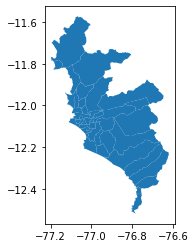

In [204]:
cond = limaMapa['provincia'] == 'LIMA'
limaMapa[cond].plot()

In [205]:
lima_distritos = np.sort(limaMapa[cond]['distrito'].unique())
lima_distritos

array(['ANCON', 'ATE', 'BARRANCO', 'BREÑA', 'CARABAYLLO', 'CHACLACAYO',
       'CHORRILLOS', 'CIENEGUILLA', 'COMAS', 'EL AGUSTINO',
       'INDEPENDENCIA', 'JESUS MARIA', 'LA MOLINA', 'LA VICTORIA', 'LIMA',
       'LINCE', 'LOS OLIVOS', 'LURIGANCHO', 'LURIN', 'MAGDALENA DEL MAR',
       'MIRAFLORES', 'PACHACAMAC', 'PUCUSANA', 'PUEBLO LIBRE',
       'PUENTE PIEDRA', 'PUNTA HERMOSA', 'PUNTA NEGRA', 'RIMAC',
       'SAN BARTOLO', 'SAN BORJA', 'SAN ISIDRO', 'SAN JUAN DE LURIGANCHO',
       'SAN JUAN DE MIRAFLORES', 'SAN LUIS', 'SAN MARTIN DE PORRES',
       'SAN MIGUEL', 'SANTA ANITA', 'SANTA MARIA DEL MAR', 'SANTA ROSA',
       'SANTIAGO DE SURCO', 'SURQUILLO', 'VILLA EL SALVADOR',
       'VILLA MARIA DEL TRIUNFO'], dtype=object)

In [206]:
import time
start = time.time()
print(start)

1629038243.773589


In [207]:
#Global vars
place_name = "puente piedra, Lima"
result = 1

In [208]:
%%time
#Getting graph from OSM
graph = ox.graph_from_place(place_name, which_result=result, network_type='drive')
nodes, edges = ox.graph_to_gdfs(graph)
print(nx.info(graph))

Name: 
Type: MultiDiGraph
Number of nodes: 6069
Number of edges: 16676
Average in degree:   2.7477
Average out degree:   2.7477
CPU times: user 13.4 s, sys: 116 ms, total: 13.5 s
Wall time: 24.6 s


In [209]:
nodes.head()

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
273353471,-11.828771,-77.119495,3,NaN,NaN,POINT (-77.11949 -11.82877)
273353473,-11.833910,-77.113129,3,35B,motorway_junction,POINT (-77.11313 -11.83391)
273353475,-11.839022,-77.106764,3,NaN,NaN,POINT (-77.10676 -11.83902)
273353476,-11.840749,-77.104574,3,NaN,NaN,POINT (-77.10457 -11.84075)
273353499,-11.874135,-77.069268,3,NaN,NaN,POINT (-77.06927 -11.87414)


In [210]:
%%time
#Getting amenities from OSM
amenities = ox.geometries_from_place(place_name, which_result=result ,tags={'amenity':True} )
amenities['isPoint'] = amenities.apply(lambda x: type(x.geometry) is Point , axis=1)
amenities.rename(columns={'geometry':'geometry_polygon'}, inplace=True)
amenities['geometry'] = amenities.apply(lambda x: x['geometry_polygon'].centroid, axis=1)
amenities.set_geometry('geometry')
amenities.set_index('osmid', inplace=True)
# amenities.head()

CPU times: user 1.19 s, sys: 16.7 ms, total: 1.21 s
Wall time: 5.92 s


In [211]:
_amenity = 'bank'
amenities_as_points = amenities[amenities['amenity'] == _amenity] 
columns = ['unique_id', 'element_type', 'geometry_polygon', 
               'amenity', 'name', 'geometry']

amenities_as_points[columns].head()

,unique_id,element_type,geometry_polygon,amenity,name,geometry
osmid,,,,,,
1863374438,node/1863374438,node,POINT (-77.07464 -11.86518),bank,Banco de la Nación,POINT (-77.07464 -11.86518)
4286938591,node/4286938591,node,POINT (-77.07446 -11.86541),bank,Interbank,POINT (-77.07446 -11.86541)
4286938893,node/4286938893,node,POINT (-77.07443 -11.86546),bank,BBVA Continental,POINT (-77.07443 -11.86546)
4287003391,node/4287003391,node,POINT (-77.07428 -11.86554),bank,SCOTIABANK Puente Piedra,POINT (-77.07428 -11.86554)
4287009092,node/4287009092,node,POINT (-77.07437 -11.86551),bank,banco BCP,POINT (-77.07437 -11.86551)


<AxesSubplot:>

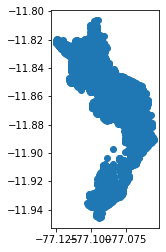

In [212]:
fig, ax = plt.subplots()
nodes.plot(ax=ax)

In [213]:
%%time
def process_amenities(_amenity):

    amenities_as_points = amenities[amenities['amenity'] == _amenity] 
    print("amenities_as_points --> {}".format(amenities_as_points.shape) )
    
    if amenities_as_points.shape[0] == 0:
        return pd.DataFrame()

    ##adding shortest amenity point for all graph nodes
    nodes_amenity = gn.pandana_snap_points( nodes , amenities_as_points ) 

    amenityid = "{}_amenity".format(_amenity)
    amenitydist = "{}_amenity_dist".format(_amenity)
    print(amenityid, amenitydist)

    nodes_amenity.rename(columns={'NN':amenityid, 'NN_dist': amenitydist}, inplace=True)

#     nodes_amenity.head()
    print("nodes_amenity --> {}".format(nodes_amenity.shape))

    ##nearest node for all amenity points
    amenities_as_points2 = gn.pandana_snap(graph, amenities_as_points) 
    print("amenities_as_points2 --> {}".format(amenities_as_points2.shape))

    ######
    columns = ['unique_id', 'element_type', 'geometry_polygon', 
               'amenity', 'name', 'geometry', 'NN', 'NN_dist']

    nodes_amenity2 = nodes_amenity.reset_index().merge(amenities_as_points2[columns], 
                                         how='left', 
                                         left_on=amenityid, 
                                         right_index=True)
    node = "{}_node".format(_amenity)
    nodedist = "{}_node_dist".format(_amenity)
    nodes_amenity2.rename(columns={'NN':node, 'NN_dist': nodedist}, inplace=True)
    print("nodes_amenity2 --> {}".format(nodes_amenity2.shape))
    
    # nodes_amenity2.head()
    #####
    def shortest_path (G, source, target, weight='length'):
        distance = np.NaN
        try:
            distance = nx.shortest_path_length(G, source, target, weight)
        except Exception as e:
            distance = np.NaN
        return distance

    nodedist = "{}_dist".format(_amenity)
    print("Calculating shortest path distance:")
    nodes_amenity2[nodedist] = nodes_amenity2.apply(lambda x:
                                                        shortest_path(graph, x['osmid'], x[node], weight='length'),
                                                        axis=1
                                                       )
    #####
    cols = ['osmid', 'geometry_x', amenityid, node, nodedist ]
#     nodes_amenity2[cols].head()
    return nodes_amenity2

CPU times: user 15 µs, sys: 5 µs, total: 20 µs
Wall time: 23.1 µs


In [214]:
# %%time
# df = process_amenities('hospital')
# df.head()

In [215]:
%%time
import ray
import time

ray.shutdown()
ray.init()
@ray.remote
def f(i):
    time.sleep(1)
    return process_amenities(i)

amenities_filter = ['bank','courthouse','hospital','marketplace', 'police','school','university']

futures = [f.remote(i) for i in amenities_filter]
# print(ray.get(futures))
# ray.get(futures[0])
futures

/usr/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 6744 is still running
  ResourceWarning, source=self)
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ray/node.py:890: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2021-08-15_09-37-57_361203_6298/logs/redis-shard_0.err' mode='a' encoding='utf-8'>
  self.start_redis()
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ray/node.py:890: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2021-08-15_09-37-57_361203_6298/logs/redis-shard_0.out' mode='a' encoding='utf-8'>
  self.start_redis()
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ray/node.py:890: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2021-08-15_09-37-57_361203_6298/logs/redis.err' mode='a' encoding='utf-8'>
  self.start_redis()
/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ray/node.py:890: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/

CPU times: user 783 ms, sys: 169 ms, total: 951 ms
Wall time: 6.39 s


[ObjectRef(11b5fcd52d49c071ffffffffffffffffffffffff0100000001000000),
 ObjectRef(a12253d7c747501cffffffffffffffffffffffff0100000001000000),
 ObjectRef(931690d20f999d2fffffffffffffffffffffffff0100000001000000),
 ObjectRef(d3ab1aaf09c00ee8ffffffffffffffffffffffff0100000001000000),
 ObjectRef(b9679322487eb9c3ffffffffffffffffffffffff0100000001000000),
 ObjectRef(fc8204747604c8ccffffffffffffffffffffffff0100000001000000),
 ObjectRef(9d78bd90898368caffffffffffffffffffffffff0100000001000000)]

In [216]:
print("asdasd")

asdasd


In [217]:
%%time
bank = ray.get(futures[0])
courthouse = ray.get(futures[1])
hospital = ray.get(futures[2])
marketplace = ray.get(futures[3])
police = ray.get(futures[4])
school = ray.get(futures[5])
university = ray.get(futures[6])

(pid=35701) amenities_as_points --> (3, 70)
(pid=35677) amenities_as_points --> (15, 70)


(pid=35701) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35701)   return _prepare_from_string(" ".join(pjargs))
(pid=35701) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35701)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=35701) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is dep

(pid=35674) amenities_as_points --> (5, 70)


(pid=35674) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35674)   return _prepare_from_string(" ".join(pjargs))
(pid=35674) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35674)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=35674) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is dep

(pid=35713) amenities_as_points --> (8, 70)
(pid=35708) amenities_as_points --> (0, 70)
(pid=35644) amenities_as_points --> (235, 70)


(pid=35713) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35713)   return _prepare_from_string(" ".join(pjargs))
(pid=35713) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35713)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=35713) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is dep

(pid=35658) amenities_as_points --> (0, 70)
(pid=35701) hospital_amenity hospital_amenity_dist
(pid=35701) nodes_amenity --> (6069, 6)


(pid=35701) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35701)   return _prepare_from_string(" ".join(pjargs))
(pid=35701) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35701)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=35701) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is dep

(pid=35674) police_amenity police_amenity_dist
(pid=35674) nodes_amenity --> (6069, 6)


(pid=35674) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35674)   return _prepare_from_string(" ".join(pjargs))
(pid=35674) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35674)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=35674) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is dep

(pid=35677) marketplace_amenity marketplace_amenity_dist
(pid=35677) nodes_amenity --> (6069, 6)


(pid=35677) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35677)   return _prepare_from_string(" ".join(pjargs))
(pid=35677) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35677)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=35677) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is dep

(pid=35713) bank_amenity bank_amenity_dist
(pid=35713) nodes_amenity --> (6069, 6)


(pid=35713) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35713)   return _prepare_from_string(" ".join(pjargs))
(pid=35713) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35713)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=35713) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is dep

(pid=35644) school_amenity school_amenity_dist
(pid=35644) nodes_amenity --> (6069, 6)


(pid=35644) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35644)   return _prepare_from_string(" ".join(pjargs))
(pid=35644) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
(pid=35644)   projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
(pid=35644) /home/leibnitz.rojas/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is dep

(pid=35674) amenities_as_points2 --> (5, 72)
(pid=35674) nodes_amenity2 --> (6069, 15)
(pid=35674) Calculating shortest path distance:
(pid=35701) amenities_as_points2 --> (3, 72)
(pid=35701) nodes_amenity2 --> (6069, 15)
(pid=35701) Calculating shortest path distance:
(pid=35677) amenities_as_points2 --> (15, 72)
(pid=35677) nodes_amenity2 --> (6069, 15)
(pid=35677) Calculating shortest path distance:
(pid=35713) amenities_as_points2 --> (8, 72)
(pid=35713) nodes_amenity2 --> (6069, 15)
(pid=35713) Calculating shortest path distance:
(pid=35644) amenities_as_points2 --> (235, 72)
(pid=35644) nodes_amenity2 --> (6069, 15)
(pid=35644) Calculating shortest path distance:
CPU times: user 27.2 s, sys: 5.86 s, total: 33.1 s
Wall time: 20min 13s


In [218]:
%%time
amenities_filter = ['bank','courthouse','hospital','marketplace', 'police','school','university']

dfcols = []
for a in amenities_filter:
    cols = ['osmid', '{}_amenity'.format(a), '{}_node'.format(a), '{}_dist'.format(a)]
    dfcols.append(cols)
#     print(cols)

dfcols

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 26.2 µs


[['osmid', 'bank_amenity', 'bank_node', 'bank_dist'],
 ['osmid', 'courthouse_amenity', 'courthouse_node', 'courthouse_dist'],
 ['osmid', 'hospital_amenity', 'hospital_node', 'hospital_dist'],
 ['osmid', 'marketplace_amenity', 'marketplace_node', 'marketplace_dist'],
 ['osmid', 'police_amenity', 'police_node', 'police_dist'],
 ['osmid', 'school_amenity', 'school_node', 'school_dist'],
 ['osmid', 'university_amenity', 'university_node', 'university_dist']]

In [219]:
# nodes.head()
pd.DataFrame([], columns = dfcols[0])
courthouse.shape[0] == 0

True

In [220]:
%%time
if bank.shape[0] == 0:
    bank = pd.DataFrame([], columns = dfcols[0])
if courthouse.shape[0] == 0:
    courthouse = pd.DataFrame([], columns = dfcols[1])
if hospital.shape[0] == 0:
    hospital = pd.DataFrame([], columns = dfcols[2])
if marketplace.shape[0] == 0:
    marketplace = pd.DataFrame([], columns = dfcols[3])
if police.shape[0] == 0:
    police = pd.DataFrame([], columns = dfcols[4])
if school.shape[0] == 0:
    school = pd.DataFrame([], columns = dfcols[5])
if university.shape[0] == 0:
    university = pd.DataFrame([], columns = dfcols[6])
    
tmp = nodes.reset_index()
tmp = tmp.merge( bank [dfcols[0]], how='left', on='osmid' )
tmp = tmp.merge( courthouse[dfcols[1]], how='left', on='osmid')
tmp = tmp.merge( hospital[dfcols[2]], how='left', on='osmid' )
tmp = tmp.merge( marketplace[dfcols[3]], how='left', on='osmid' )
tmp = tmp.merge( police[dfcols[4]], how='left', on='osmid' )
tmp = tmp.merge( school[dfcols[5]], how='left', on='osmid' )
tmp = tmp.merge( university[dfcols[6]], how='left', on='osmid' )
tmp.head()

CPU times: user 203 ms, sys: 1.82 ms, total: 205 ms
Wall time: 201 ms


,osmid,y,x,street_count,ref,highway,geometry,bank_amenity,bank_node,bank_dist,courthouse_amenity,courthouse_node,courthouse_dist,hospital_amenity,hospital_node,hospital_dist,marketplace_amenity,marketplace_node,marketplace_dist,police_amenity,police_node,police_dist,school_amenity,school_node,school_dist,university_amenity,university_node,university_dist
0,273353471,-11.828771,-77.119495,3,NaN,NaN,POINT (-77.11949 -11.82877),435323606,863519212,6315.198,NaN,NaN,NaN,405698392,273353471,0.000,399069247,1756231313,1885.077,319481153,2480656130,1820.899,5567460454,1756231263,2049.876,NaN,NaN,NaN
1,273353473,-11.833910,-77.113129,3,35B,motorway_junction,POINT (-77.11313 -11.83391),435323606,863519212,5417.077,NaN,NaN,NaN,405698392,273353471,3354.008,399069247,1756231313,2260.223,319481153,2480656130,2196.045,5567485611,1756212137,1298.125,NaN,NaN,NaN
2,273353475,-11.839022,-77.106764,3,NaN,NaN,POINT (-77.10676 -11.83902),435323606,863519212,4520.743,NaN,NaN,NaN,405698392,273353471,3784.442,8204207342,7575681832,786.293,4553175289,8088984630,1521.372,4286397814,273353475,0.000,NaN,NaN,NaN
3,273353476,-11.840749,-77.104574,3,NaN,NaN,POINT (-77.10457 -11.84075),435323606,863519212,4214.676,NaN,NaN,NaN,405698392,273353471,3702.720,8204207342,7575681832,480.226,4553175289,8088984630,1417.563,5567498334,2502194097,1066.267,NaN,NaN,NaN
4,273353499,-11.874135,-77.069268,3,NaN,NaN,POINT (-77.06927 -11.87414),6190518187,863427836,2061.009,NaN,NaN,NaN,465561830,5056593438,3519.579,835657632,1755125303,4313.563,319483701,863427809,2155.831,435367362,1755155472,1353.526,NaN,NaN,NaN


In [221]:
name = place_name.split(',')[0].replace(' ','_')
filename = "simbig21data/{}.csv".format(name)
tmp.to_csv( filename, index=False)

In [222]:
df = pd.read_csv(filename)
df.head()

,osmid,y,x,street_count,ref,highway,geometry,bank_amenity,bank_node,bank_dist,courthouse_amenity,courthouse_node,courthouse_dist,hospital_amenity,hospital_node,hospital_dist,marketplace_amenity,marketplace_node,marketplace_dist,police_amenity,police_node,police_dist,school_amenity,school_node,school_dist,university_amenity,university_node,university_dist
0,273353471,-11.828771,-77.119495,3,NaN,NaN,POINT (-77.1194946 -11.8287714),435323606,863519212,6315.198,NaN,NaN,NaN,405698392,273353471,0.000,399069247,1756231313,1885.077,319481153,2480656130,1820.899,5567460454,1756231263,2049.876,NaN,NaN,NaN
1,273353473,-11.833910,-77.113129,3,35B,motorway_junction,POINT (-77.1131285 -11.8339095),435323606,863519212,5417.077,NaN,NaN,NaN,405698392,273353471,3354.008,399069247,1756231313,2260.223,319481153,2480656130,2196.045,5567485611,1756212137,1298.125,NaN,NaN,NaN
2,273353475,-11.839022,-77.106764,3,NaN,NaN,POINT (-77.1067638 -11.8390221),435323606,863519212,4520.743,NaN,NaN,NaN,405698392,273353471,3784.442,8204207342,7575681832,786.293,4553175289,8088984630,1521.372,4286397814,273353475,0.000,NaN,NaN,NaN
3,273353476,-11.840749,-77.104574,3,NaN,NaN,POINT (-77.10457359999999 -11.8407485),435323606,863519212,4214.676,NaN,NaN,NaN,405698392,273353471,3702.720,8204207342,7575681832,480.226,4553175289,8088984630,1417.563,5567498334,2502194097,1066.267,NaN,NaN,NaN
4,273353499,-11.874135,-77.069268,3,NaN,NaN,POINT (-77.06926780000001 -11.8741354),6190518187,863427836,2061.009,NaN,NaN,NaN,465561830,5056593438,3519.579,835657632,1755125303,4313.563,319483701,863427809,2155.831,435367362,1755155472,1353.526,NaN,NaN,NaN


In [223]:
end = time.time()
print("Processing time : {} secods".format(end-start))

Processing time : 1251.5211849212646 secods
